In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import os
from PIL import Image

from utils import load_data , kernel_function , gif_function

## Kernel K-Means

For kernel k-means clustering, we use two different initialization method. 
1. K-means++: \
$\quad$ (1) Choose one center uniformly at random among the data points. \
$\quad$ (2) For each data point x not chosen yet, compute D(x), the distance between x and the nearest center that has already been chosen. \
$\quad$ (3) Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to $D(x)^2$. \
$\quad$ (4) Repeat Steps 2 and 3 until k centers have been chosen.

2. Random: \
Randomly pick k data points as the initial centroids. \

And we compute the kmeans clustering using the initialize centroids above. The alogorithms of kmeans we used is Lloyd's algorithm. For the E-step (expectation step), we keep $\mu_k$ fixed, and minimize $J = \sum_{n+1}^{N}\sum_{k=1}^{K}r_{nk}||x_i - x_j||^2$ with respect to $r_{nk} \in \{0,1\}$. And for the M-step (maximization step), we keep $r_{nk}$ fixed, and minimize $J$ with respect to $\mu_k$. Repeat this procedure, until $\mu_k$ is converge.


In [7]:
class Kmeans:
    def __init__(self, cluster, init):
        self.K = cluster
        self.init = init

    def initialization(self , init , data):
        init_mean = np.zeros((self.K , data.shape[1]))
        ## use kmeans++ to find the initral center
        if init == "kmeans++":
            ## randomly selected a data point as the first centroid
            init_mean[0] = data[np.random.randint(low = 0 , high = data.shape[0] , size = 1) , :]

            ## find another k-1 centroid 
            for k in range(1,self.K):
                k_dist = np.zeros((data.shape[0] , k))

                for i in range(k):
                    k_dist[:,i] = np.sqrt(np.sum((data- init_mean[i])**2 , axis = 1))
                d_x = np.min(k_dist , axis = 1)
                sum_d = np.sum(d_x)*np.random.rand()
                for j in range(len(data)):
                    sum_d -= d_x[j]
                    if sum_d <= 0:
                        init_mean[k] = data[j]
                        break

        ## randomly choose k initial centroids
        elif init == "random":
            # np.random.seed(5)
            init_mean = data[np.random.randint(low = 0 , high = data.shape[0] , size = self.K) , :]

        return init_mean

    def train(self , png_dir , image_array , h , w):
        if not os.path.exists(png_dir):
            os.makedirs(png_dir)
            
        cluster = np.zeros((len(image_array)))
        ## find initial center using different method
        init_mean = self.initialization(self.init , image_array)
        mean = np.copy(init_mean)
        eps = 1e-9
        for i in range(1000):
            ## Expectation step
            dist = []
            ## classify all samples according to closet mu_k
            for j in range(self.K):
                dist.append(np.sqrt(np.sum((image_array - mean[j])**2 , axis = 1)))
            cluster = np.argmin(dist , axis = 0)

            # Maximization step
            new_mean = np.zeros(mean.shape)
            ## recompute as the mean mu_k of the points in cluter C_k
            for j in range(self.K):
                new_mean[j] = np.sum(image_array[np.argwhere(cluster == j),:] , axis = 0)
                if np.sum(cluster == j) > 0:
                    new_mean[j] /= np.sum(cluster == j)

            diff = np.sum((new_mean - mean)**2)
            mean = new_mean

            ## visualization of current clustering result
            print("iteration: {} diff: {:.6f}".format(i , diff))
            plt.imshow(cluster.reshape(h, w))
            # plt.show()
            plt.savefig(os.path.join(png_dir,'frame_'+str(i)+'.png'),dpi=100)
            plt.close()          
            if diff < eps:
                break
        
        ## creating gif file 
        gif_function(png_dir)       


The kernel function we used is defined below:
$$k(x,x') = e^{-\gamma_s||S(x)-S(x')||^2} \times e^{-\gamma_c||C(x)-C(x')||^2}$$
We set the $\gamma_s$ to 0.001 and $\gamma_c$ to 0.001.

iteration: 0 diff: 244.525944


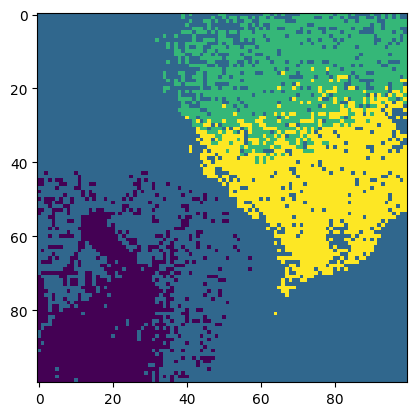

iteration: 1 diff: 3.006782


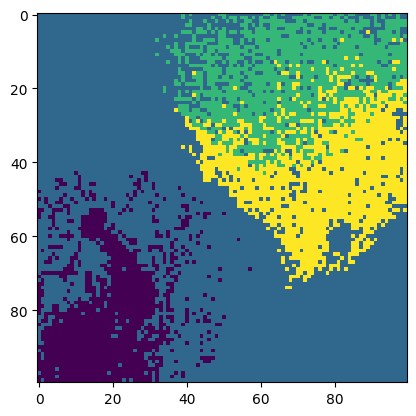

iteration: 2 diff: 2.352987


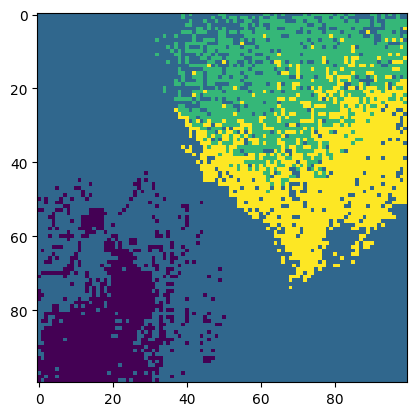

iteration: 3 diff: 1.759184


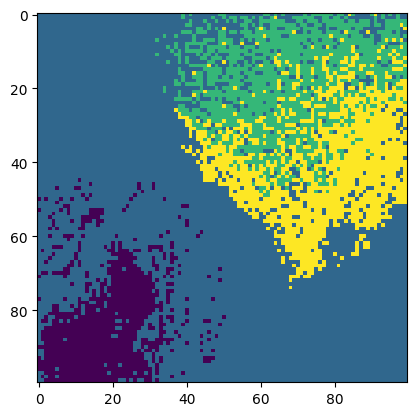

iteration: 4 diff: 0.936148


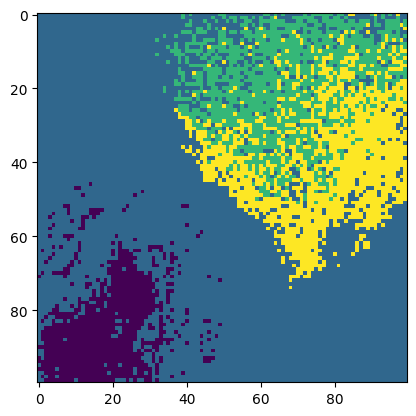

iteration: 5 diff: 0.559892


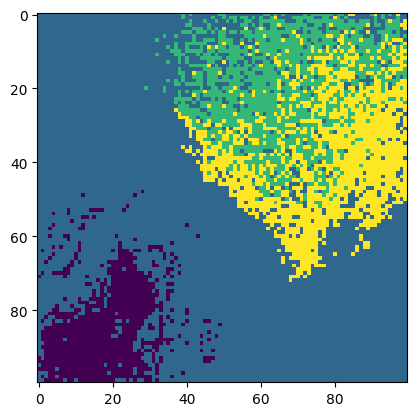

iteration: 6 diff: 0.263217


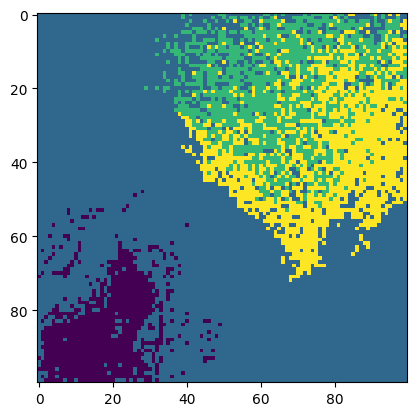

iteration: 7 diff: 0.118955


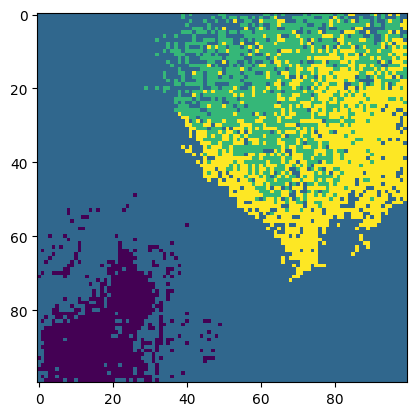

iteration: 8 diff: 0.054253


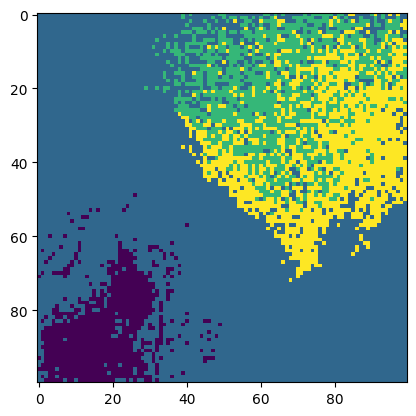

iteration: 9 diff: 0.046171


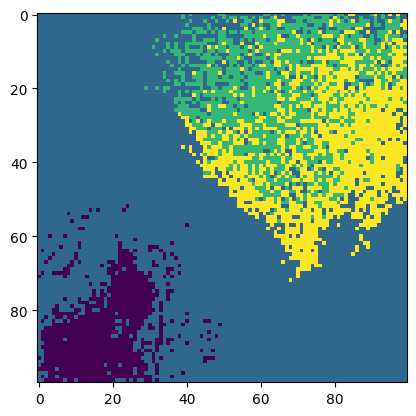

iteration: 10 diff: 0.013350


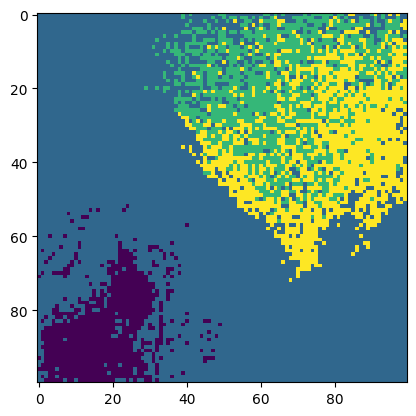

iteration: 11 diff: 0.018588


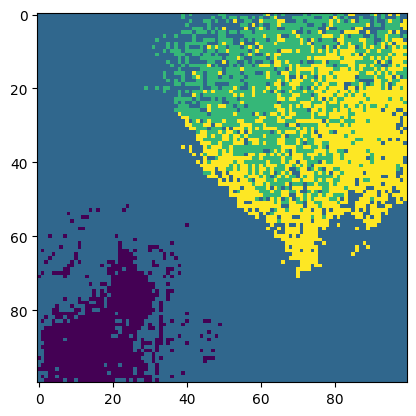

iteration: 12 diff: 0.018511


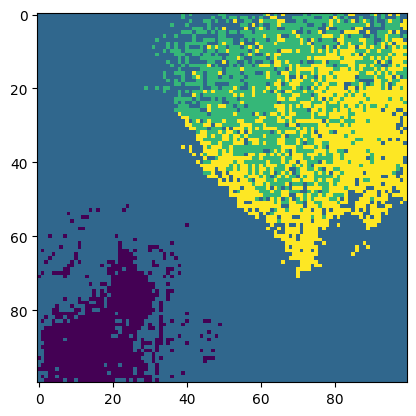

iteration: 13 diff: 0.027003


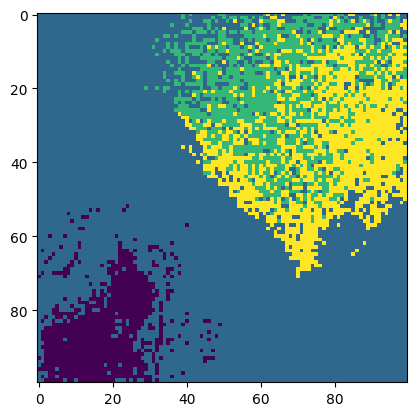

iteration: 14 diff: 0.031106


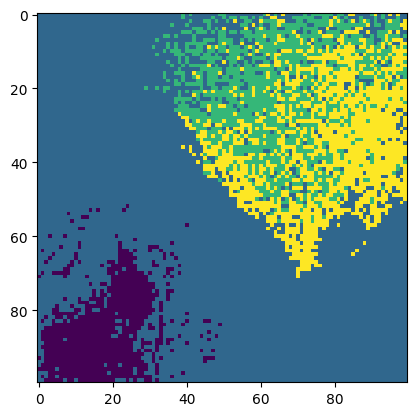

iteration: 15 diff: 0.019707


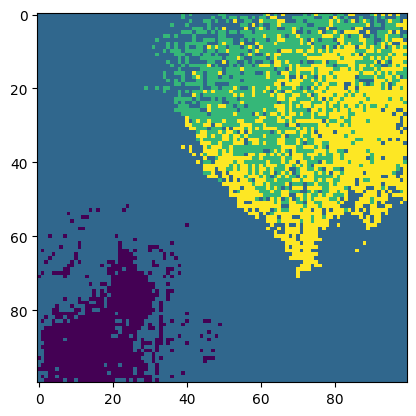

iteration: 16 diff: 0.016679


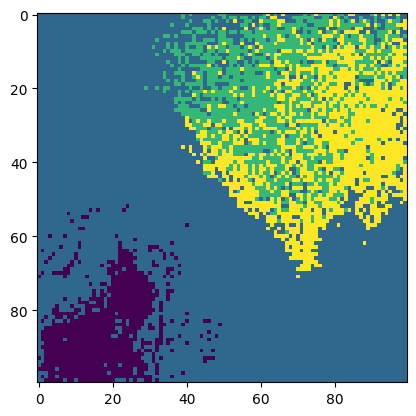

iteration: 17 diff: 0.009625


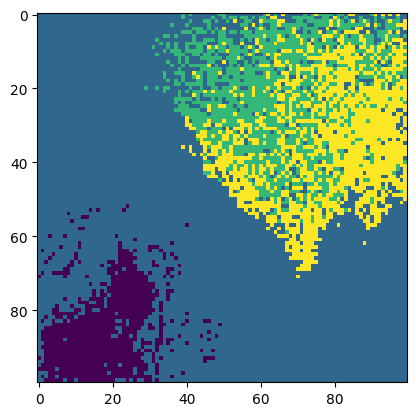

iteration: 18 diff: 0.003618


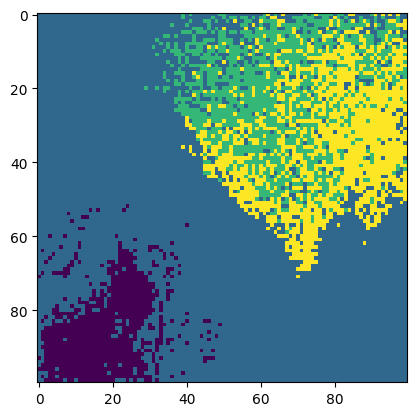

iteration: 19 diff: 0.000592


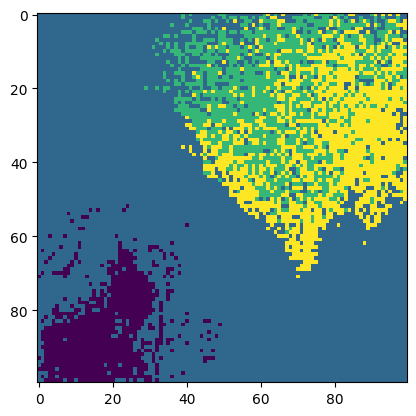

iteration: 20 diff: 0.001087


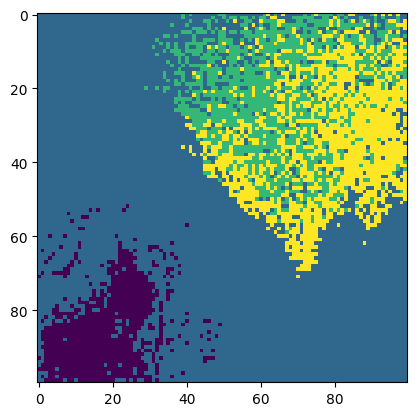

iteration: 21 diff: 0.000162


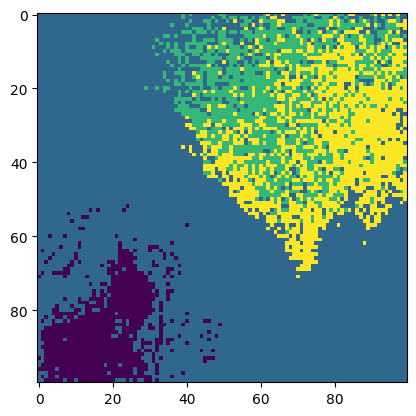

iteration: 22 diff: 0.000000


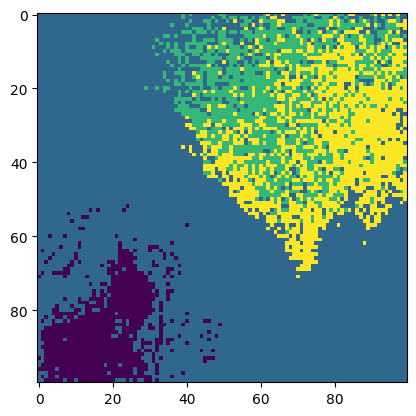

In [140]:
data , height , width = load_data("/Users/cindychen/Documents/ML_HW06/image1.png")

gamma_s = 0.001
gamma_c = 0.001
## compute kernel function with gamma s equals to 0.001 and gamma c equals to 0.001
image_array = kernel_function(data, gamma_s , gamma_c)

model = Kmeans(4, "random")
gif_dir = "/Users/cindychen/Documents/ML_HW06_output/kmeans_4"
map = model.train(gif_dir , image_array , height , width)

For the result of the two different initialization methods, we can see that by using kmeans++ method the clustering converges much quicker with less iterations and less time. 

## Spectral Clustering

For Spectral Clustering, we also used two different methods to cluster which is normalize cut and ratio cut.

In [3]:
class Spectral_Cluster:
    def __init__(self , cluster , image_array ):
        self.K = cluster
        self.image_array = image_array

    def normalize_cut(self , eig_path , vec_path):
        if os.path.exists(eig_path) and os.path.exists(vec_path):
            eigenvalue = np.load(eig_path)
            eigenvector = np.load(vec_path)
        
        else:
            ## similarity matrix
            W = self.image_array
            ## degree matrix
            D = np.diag(np.sum(W , axis = 1))
            L = D - W
            ## compute normalize laplacian matrix L_sym = D^(-1/2)LD^(-1/2)
            L_sym = np.diag(1/np.diag(np.sqrt(D)))@L@np.diag(1/np.diag(np.sqrt(D)))

            eigenvalue , eigenvector = np.linalg.eig(L_sym)
            np.save(eig_path , eigenvalue)
            np.save(vec_path , eigenvector)

        sort_idx = np.argsort(eigenvalue)
        U = eigenvector[:,sort_idx[:self.K]]

        T = U/np.sqrt(np.sum(U**2 , axis = 1)).reshape(-1 ,1)
        return T
        

    def ratio_cut(self , eig_path , vec_path):
        if os.path.exists(eig_path) and os.path.exists(vec_path):
            eigenvalue = np.load(eig_path)
            eigenvector = np.load(vec_path)

        else:
            ## similarity matrix
            W = self.image_array
            D = np.diag(np.sum(W , axis = 1))
            ## compute unormalize laplacian matrix
            L = D - W

            eigenvalue , eigenvector = np.linalg.eig(L)
            np.save(eig_path , eigenvalue)
            np.save(vec_path , eigenvector)

        sort_idx = np.argsort(eigenvalue)
        U = eigenvector[:,sort_idx[:self.K]]

        return U
    

In [10]:
data , height , width = load_data("/Users/cindychen/Documents/ML_HW06/image1.png")

gamma_s = 0.001
gamma_c = 0.001
## compute kernel function with gamma s equals to 0.001 and gamma c equals to 0.001
image_array = kernel_function(data, gamma_s , gamma_c)

eig_path = "/Users/cindychen/Documents/ML_HW6_310657012_陳芃辰/eigenvalue_image1_0.001_0.001_ratio.npy"
vec_path = "/Users/cindychen/Documents/ML_HW6_310657012_陳芃辰/eigenvector_image1_0.001_0.001_ratio.npy"
spectral = Spectral_Cluster(4 , image_array)
## using normalize cut and ratio cut to compute the spectral clustering
process_array = spectral.normalize_cut(eig_path , vec_path)
process_array = spectral.ratio_cut(eig_path , vec_path)

## after using spectral clustering put the pre-processed data into kmeans for classification
model_2 = Kmeans(4, "random")
gif_dir = "/Users/cindychen/Documents/ML_HW06_output/spectral_4_ratio"
model_2.train(gif_dir , process_array , height , width)

iteration: 0 diff: 0.000002
iteration: 1 diff: 0.000016
iteration: 2 diff: 0.000043
iteration: 3 diff: 0.000009
iteration: 4 diff: 0.000005
iteration: 5 diff: 0.000001
iteration: 6 diff: 0.000000
iteration: 7 diff: 0.000000
iteration: 8 diff: 0.000000


iteration: 0 diff: 0.184725


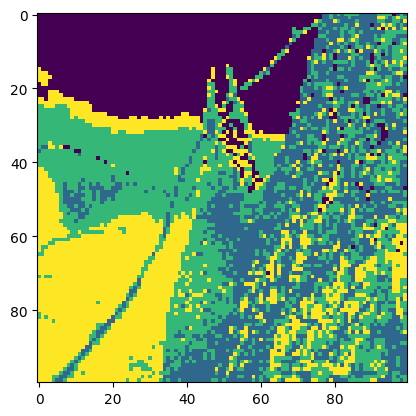

iteration: 1 diff: 0.011629


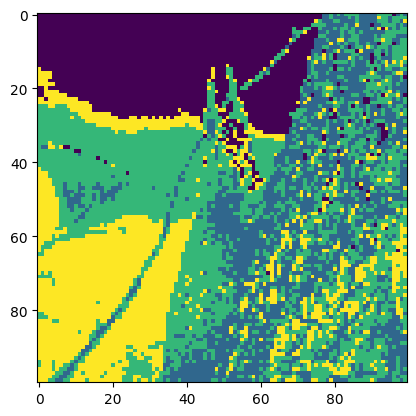

iteration: 2 diff: 0.001115


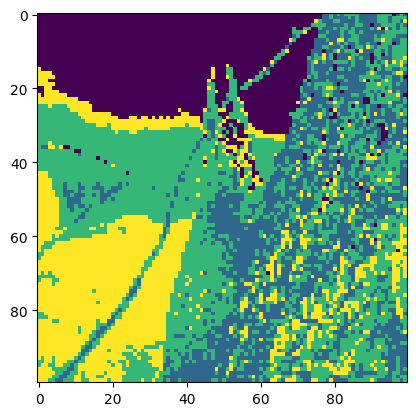

iteration: 3 diff: 0.000098


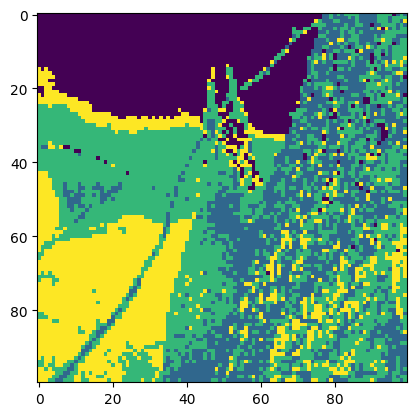

iteration: 4 diff: 0.000007


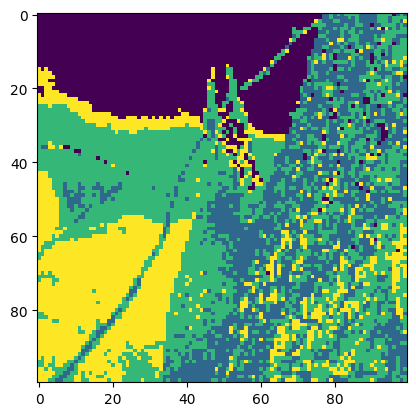

iteration: 5 diff: 0.000001


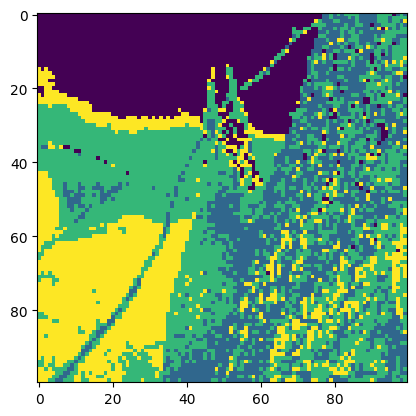

iteration: 6 diff: 0.000000


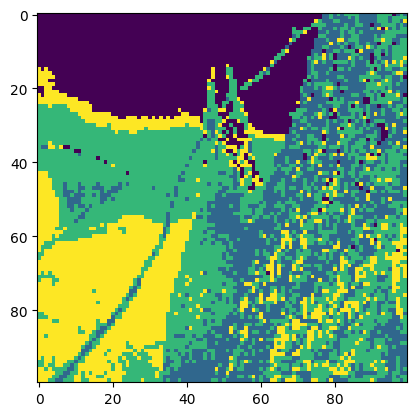

iteration: 7 diff: 0.000000


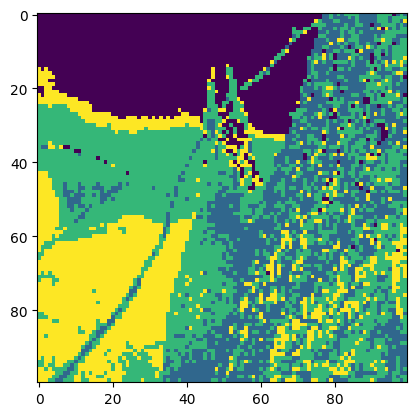

In [142]:
data , height , width = load_data("/Users/cindychen/Documents/ML_HW06/image2.png")

gamma_s = 0.001
gamma_c = 0.001
image_array = kernel_function(data, gamma_s , gamma_c)

eig_path = "/Users/cindychen/Documents/ML_HW6_310657012_陳芃辰/eigenvalue_image2_0.001_0.001.npy"
vec_path = "/Users/cindychen/Documents/ML_HW6_310657012_陳芃辰/eigenvector_image2_0.001_0.001.npy"
spectral = Spectral_Cluster(4 , image_array)
# process_array = spectral.ratio_cut(eig_path , vec_path)
process_array = spectral.normalize_cut(eig_path , vec_path)

model_2 = Kmeans(4, "kmeans++")
gif_dir = "/Users/cindychen/Documents/ML_HW06_output/spectral++2_4"
model_2.train(gif_dir , process_array , height , width)